In [31]:
# !pip install -r requirements.txt
!pip install keras-self-attention

# 0. 라이브러리

# 1. Load Data

In [32]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [ ]:
# from tensorflow.python.client import device_lib
# tf.config.list_physical_devices('GPU')

In [ ]:
seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# data load

path = '/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/'

# # 5-core
# with open(path +'5c_Sparsity_movies_train.pkl', 'rb') as f:
#     train_set5 = pickle.load(f)
# with open(path +'5c_Sparsity_movies_test.pkl', 'rb') as f:
#     test_set5 = pickle.load(f)
# with open(path +'5c_Sparsity_movies_validation.pkl', 'rb') as f:
#     valid_set5 = pickle.load(f)

# 10-core
with open(path +'10c_Sparsity_movies_train.pkl', 'rb') as f:
    train_set10 = pickle.load(f)
with open(path +'10c_Sparsity_movies_test.pkl', 'rb') as f:
    test_set10 = pickle.load(f)
with open(path +'10c_Sparsity_movies_validation.pkl', 'rb') as f:
    valid_set10 = pickle.load(f)


# 20-core
with open(path +'20c_Sparsity_movies_train.pkl', 'rb') as f:
    train_set20 = pickle.load(f)
with open(path +'20c_Sparsity_movies_test.pkl', 'rb') as f:
    test_set20 = pickle.load(f)
with open(path +'20c_Sparsity_movies_validation.pkl', 'rb') as f:
    valid_set20 = pickle.load(f)

# 30-core
with open(path +'30c_Sparsity_movies_train.pkl', 'rb') as f:
    train_set30 = pickle.load(f)
with open(path +'30c_Sparsity_movies_test.pkl', 'rb') as f:
    test_set30 = pickle.load(f)
with open(path +'30c_Sparsity_movies_validation.pkl', 'rb') as f:
    valid_set30 = pickle.load(f)


### 데이터별 유저, 아이템 수
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- -----
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- -----
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- -----
- 30core userID num :  137344
- 30core movieID num :  41479
- 30core rating num :  331559

In [35]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set10['rating'] = norm(train_set10['rating'])
valid_set10['rating'] = norm(valid_set10['rating'])

train_set30['rating'] = norm(train_set30['rating'])
valid_set30['rating'] = norm(valid_set30['rating'])

train_set20['rating'] = norm(train_set20['rating'])
valid_set20['rating'] = norm(valid_set20['rating'])

# train_set5['rating'] = norm(train_set5['rating'])
# valid_set5['rating'] = norm(valid_set5['rating'])

# 3.Model

In [36]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    pos_input = Input(shape=(1,), dtype='int32', name='PosInput')
    pos_dense = Dense(units=1, activation='relu', name='Dense_Pos')(pos_input)

    neg_input = Input(shape=(1,), dtype='int32', name='NegInput')
    neg_dense = Dense(units=1, activation='relu', name='Dense_Neg')(neg_input)

    neu_input = Input(shape=(1,), dtype='int32', name='NeuInput')
    neu_dense = Dense(units=1, activation='relu', name='Dense_Neu')(neu_input)

    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)

    # disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    # disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    # joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    # joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    # sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    # sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    # surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    # surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    # trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    # trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, pos_dense, neg_dense, neu_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, pos_input, neg_input, neu_input ], outputs=outputs)
    return model

In [ ]:
user_num = 281335
item_num = 59044

id_dims = 128# each 32 dims
total_layer_dims = 32 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

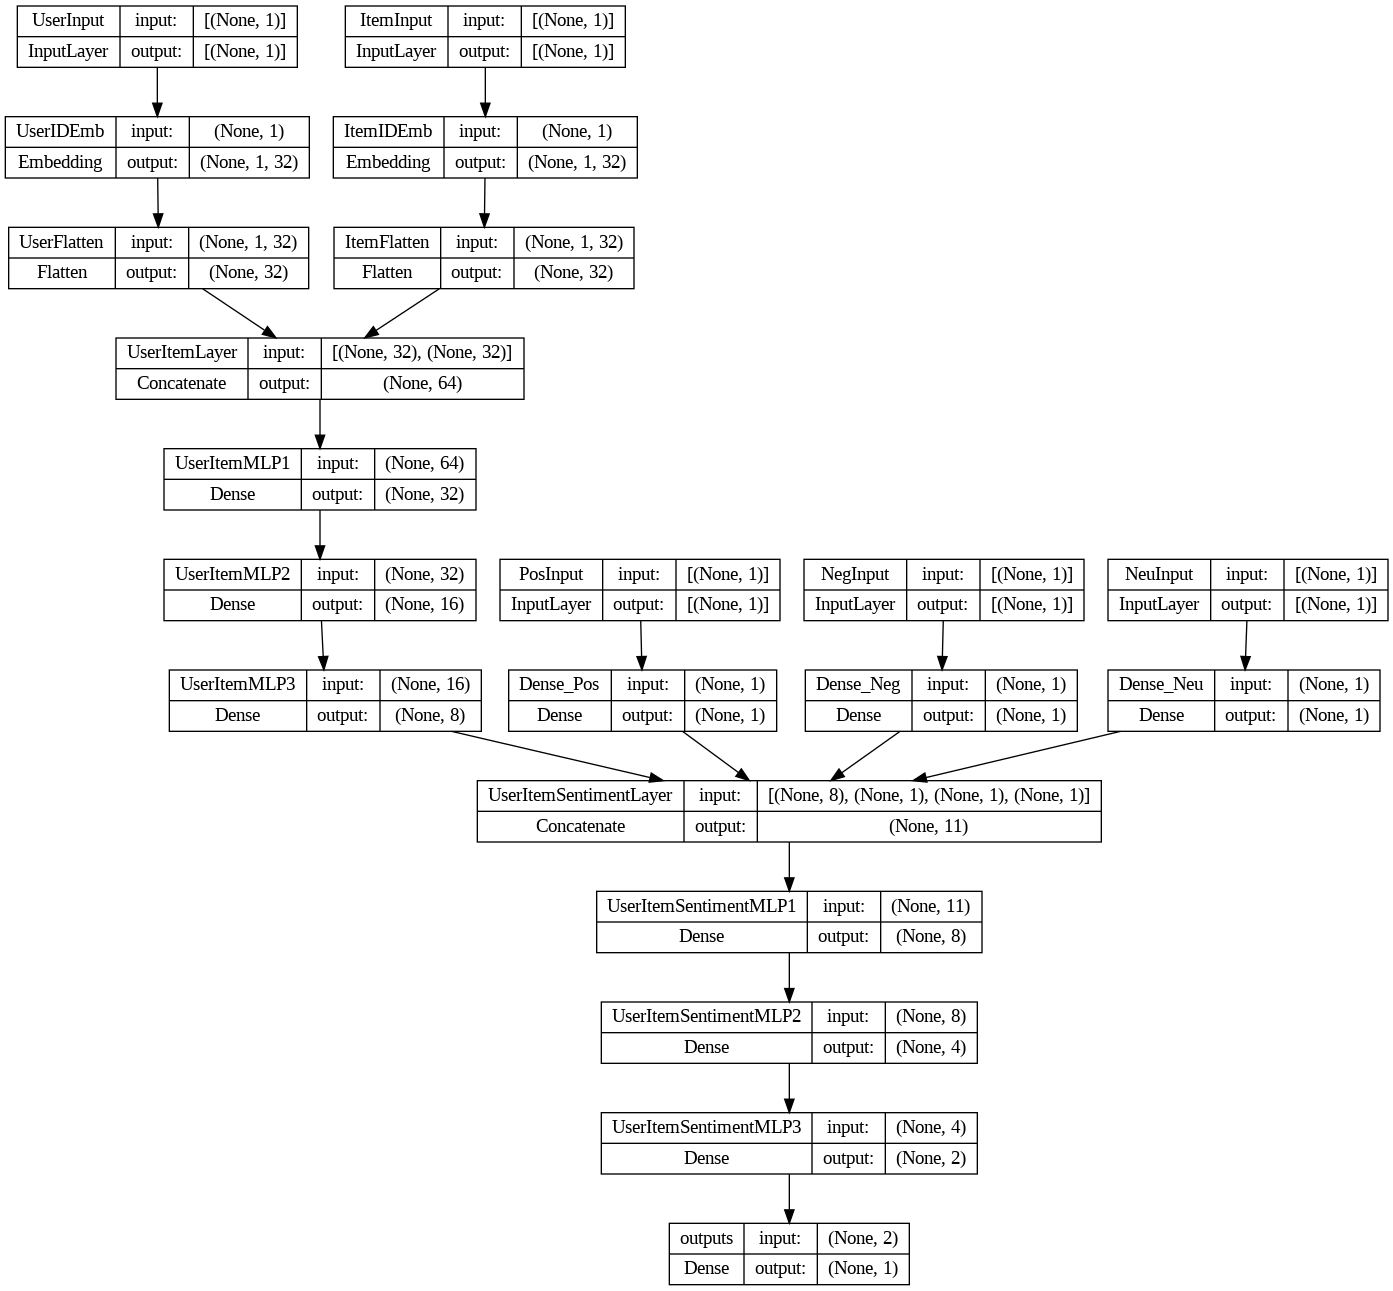

In [ ]:
model = ModelBuild(user_num = 281335, item_num = 59044, id_dims = 32, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)
plot_model(model, show_shapes=True, show_layer_names=True)

## Jihyeon:모든 파라미터에 대해 돌려보기
- id_dim = [256, 128, 64, 32]
- n layer = 3 고정
- layer_dim = [128, 64, 32, 16]
- lr = [0.0005, 0.0001, 0.005, 0.001]

In [ ]:
def model_run_param(train_set, valid_set, test_set,id_dims, total_layer_dims,total_n_layer,lr):

    # param_embedding, param_layer_dim, param_lr = [],[],[]
    # MAE, RMSE = [], []
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['pos'], train_set['neg'], train_set['neu']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['pos'],valid_set['neg'],valid_set['neu'] ],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['pos'], test_set['neg'], test_set['neu']])

    # normalize 안해도 되겠단 생각이..
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

### 데이터별 유저, 아이템 수
- 5core userID num :  2851
- 5core movieID num :  2390
- 5core rating num :  3059
- ----------
- 10core userID num :  38277
- 10core movieID num :  19809
- 10core rating num :  53141
- ----------
- 20core userID num :  100088
- 20core movieID num :  34950
- 20core rating num :  194688
- ----------
- 30core userID num :  137344
- 30core movieID num :  41479
- 30core rating num :  331559

### 실험1 - 5core
- 5core userID num :  2851
- 5core movieID num :  2390
- 5core rating num :  3059

In [ ]:
# # sparsity 계산
# sparsity_5 = 1- (3059 / (2851*2390))
# print('5-core data sparsity: ',sparsity_5)

In [ ]:
# '''
# - 5core userID num :  2851
# - 5core movieID num :  2390
# - 5core rating num :  3059
# '''
# user_num = 2851
# item_num = 2390

# id_dims = [128, 64, 32]
# total_layer_dims =  [128, 64,32]
# total_n_layer = 3
# lr = [0.001, 0.005]

# train_set = train_set5
# valid_set = valid_set5
# test_set = test_set5

In [ ]:
# MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
# for a in id_dims:
#   for b in total_layer_dims:
#     for i in lr:
#       MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(train_set, valid_set, test_set, a, b,3,i)

#       MAE.append(MAE_temp)
#       RMSE.append(RMSE_temp)
#       param_embedding.append(embedding_size)
#       param_layer_dim.append(layer_dim)
#       param_lr.append(learning_rate)

In [ ]:
# param5 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
# param5

### 실험2 - 10core
- 10core userID num :  38277
- 10core movieID num :  19809
- 10core rating num :  53141

In [ ]:
# sparsity 계산
sparsity_10 =1- (53141 / (38277*19809))
print('10-core data sparsity: ',sparsity_10)

10-core data sparsity:  0.9999299143220821


In [39]:
'''
- 10core userID num :  38277
- 10core movieID num :  19809
- 10core rating num :  53141
'''
user_num = 38277
item_num = 19809

id_dims = [128, 64, 32]
total_layer_dims =  [128, 64,32]
total_n_layer = 3
lr = [0.001, 0.005]

train_set = train_set10
valid_set = valid_set10
test_set = test_set10

In [ ]:
param10 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
param10

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.957521,1.216192
1,128,128,0.005,0.910627,1.221824
2,128,64,0.001,0.914292,1.221039
3,128,64,0.005,0.979506,1.250422
4,128,32,0.001,1.026471,1.265925
5,128,32,0.005,0.960297,1.230990
6,64,128,0.001,0.970308,1.227566
7,64,128,0.005,0.915039,1.226651
8,64,64,0.001,0.920735,1.227080
9,64,64,0.005,0.958990,1.262719


### 실험3 - 20core
- 20core userID num :  100088
- 20core movieID num :  34950
- 20core rating num :  194688

In [ ]:
# sparsity 계산
sparsity_20 = 1- (194688 / (100088*34950))
print('20-core data sparsity: ',sparsity_20)

20-core data sparsity:  0.9999443442560246


In [ ]:
'''
- 20core userID num :  100088
- 20core movieID num :  34950
- 20core rating num :  194688
'''

user_num = 100088
item_num = 34950

id_dims = [128, 64,32]
total_layer_dims =  [128, 64,32]
total_n_layer = 3
lr = [0.001, 0.005]

train_set = train_set20
valid_set = valid_set20
test_set = test_set20

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(train_set, valid_set, test_set, a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
134/134 [==============================] - 12s 61ms/step - loss: 0.5434 - val_loss: 0.4719
Epoch 2/100
134/134 [==============================] - 1s 8ms/step - loss: 0.3742 - val_loss: 0.4835
Epoch 3/100
134/134 [==============================] - 2s 15ms/step - loss: 0.2975 - val_loss: 0.5206
Epoch 4/100
134/134 [==============================] - 2s 12ms/step - loss: 0.2616 - val_loss: 0.5720
Epoch 4: early stopping
1217/1217 [==============================] - 2s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.889
RMSE: 1.164
Epoch 1/100
134/134 [==============================] - 10s 47ms/step - loss: 0.5014 - val_loss: 0.4646
Epoch 2/100
134/134 [==============================] - 1s 7ms/step - loss: 0.3386 - val_loss: 0.5012
Epoch 3/100
134/134 [==============================] - 2s 12ms/step - loss: 0.2828 - val_loss: 0.5572
Epoch 4/100
134/134 [==============================] - 1s 10ms/step - loss: 0.2432 - val_loss: 0.6408
Epoch 4: early stopping
1217/1217 [=======

In [ ]:
param20 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
param20

### 실험4 - 30core
- 30core userID num :  137344
- 30core movieID num :  41479
- 30core rating num :  331559

In [ ]:
# sparsity 계산
sparsity_30 = 1 - (331559 / (137344*41479))
print('30-core data sparsity: ',sparsity_30)

In [ ]:
'''
- 30core userID num :  137344
- 30core movieID num :  41479
- 30core rating num :  331559
'''

user_num = 137344
item_num = 41479

id_dims = [128, 64,32]
total_layer_dims =  [128, 64,32]
total_n_layer = 3
lr = [0.001, 0.005]

train_set = train_set30
valid_set = valid_set30
test_set = test_set30

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(train_set, valid_set, test_set, a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

In [ ]:
param30 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
param30

# 결과 저장

In [ ]:
# param10
param10.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/10core_sparsity_sentiMLP_result.csv", index=False)

# param5
# param5.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/5core_sparsity_sentiMLP_result.csv", index=False)

# param20
param20.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/20core_sparsity_sentiMLP_result.csv", index=False)

# param30
param30.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/30core_sparsity_sentiMLP_result.csv", index=False)

In [ ]:
# # 번외 sparsity
# '''

# - 5core userID num :  2851
# - 5core movieID num :  2390
# - 5core rating num :  3059
# - ----------
# - 10core userID num :  38277
# - 10core movieID num :  19809
# - 10core rating num :  53141
# - ----------
# - 20core userID num :  100088
# - 20core movieID num :  34950
# - 20core rating num :  194688
# - ----------
# - 30core userID num :  137344
# - 30core movieID num :  41479
# - 30core rating num :  331559
# '''

# n_core = ['5-core','10-core','20-core','30-core']
# user_num = [2851, 38277, 100088, 137344]
# movie_num = [2390, 19809, 34950, 41479]
# rating_num = [3059, 53141, 194688, 331559]
# # sparsity = [0.0004489359235326664, 0.0007484205326408776, 0.0018993736461126469, 0.004380935806310133]

In [ ]:
# sparsity_df = pd.DataFrame(zip(n_core, user_num, movie_num, rating_num), columns=['n_core','user_num','movie_num','rating_num'])
# sparsity_df